# NETFLIX 
Etude des films et séries disponibles sur Netflix by Aurélie RAOUL

In [1]:
# imports
from builtins import set
from time import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

In [2]:
verbose = False

## 1. Lecture du fichier

### 1.1 Lecture du fichier
- Lecture du fichier


In [240]:
# ---------------------------------------------------------------------------------------------
#                               Chargement du fichier
# ---------------------------------------------------------------------------------------------
# Lecture du fichier :
print("Chargement des données....")
df = pd.read_csv('C:\\Users\\User\\Documents\\workspace-simplon\\mois-01\\semaine4-Simplon\\netflix_titles.csv', sep=',')
print("Chargement des données........ END")

Chargement des données....
Chargement des données........ END


### 1.2 Dimension des données
- Dimension du dataframe
- Combien y a-t-il de films dans ce jeu de données ?
- Combien y a-t-il de séries ?
- Générer le résumé statistique du dataframe
- Compter les valeurs manquantes

In [4]:
# ---------------------------------------------------------------------------------------------
#                               PREPARATION DES DONNEES
# ---------------------------------------------------------------------------------------------
#                                     Dimensions

In [5]:
def get_nb_of_type(df, type, verbose=False):
    """
    Retourne le nombre d'éléments du type demandé en paramètre
    :param df: DataFrame
    :param type : String - type recherché
    :param verbose : Boolean - True pour mode debug
    :return: le nombre d'éléments du type demandé en paramètre
    """
    t0 = time()
    nb_type = 0
    types_count = df["type"].value_counts()
    for t,v in types_count.items():
        if t == type:
            nb_type = v
            break
    t1 = time() - t0
    print("get_nb_of_type in {0:.3f} secondes................... END".format(t1))
    return nb_type

In [143]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|             Dimension du dataframe            |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Dimension du dataframe", df.shape)
print("Combien par type:\n", df["type"].value_counts())
nb_film = get_nb_of_type(df, "Movie", verbose)
print("Combien y a-t-il de films dans ce jeu de données ?", nb_film, "soit:", (nb_film/df.shape[0])*100)
nb_series = get_nb_of_type(df, "TV Show", verbose)
print("Combien y a-t-il de séries ?", nb_series, "soit:", (nb_series/df.shape[0])*100)
print("Générer le résumé statistique du dataframe")
df.describe()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|             Dimension du dataframe            |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Dimension du dataframe (8807, 14)
Combien par type:
 Movie      6131
TV Show    2676
Name: type, dtype: int64
get_nb_of_type in 0.000 secondes................... END
Combien y a-t-il de films dans ce jeu de données ? 6131 soit: 69.61507891449983
get_nb_of_type in 0.000 secondes................... END
Combien y a-t-il de séries ? 2676 soit: 30.38492108550017
Générer le résumé statistique du dataframe


,release_year,duration time
count,8807.000000,8807.000000
mean,2014.180198,69.848530
std,8.819312,50.806431
min,1925.000000,1.000000
25%,2013.000000,2.000000
50%,2017.000000,88.000000
75%,2019.000000,106.000000
max,2021.000000,312.000000


70 % du contenu Netflix sont des films (par rapport à cette source données)    
L'étude des données pourrait avoir pour objectif de développer les contenus de type séries et donc d'identifier les axes fort.    
Ou cette étude pourrait porter sur les appétences des utilisateurs en fonction de leur profil (il faudrait coupler ces données avec les utilisateurs)    
Suivant l'objectif de l'étude, cette information est vitale pour comprendre les chiffres et orienter l'analyse et les conclusion    

### 1.3 Préparation des données

Traitement des types de données :
 - Type = Catégorie
 - Rating = Catégorie
 - date_added = Date
 - duration = ajout d'une colonne avec la durée numérique
 - country = correction des pays
 - annee = ajout d'une colonne de type date basée sur release_year

In [228]:
# ---------------------------------------------------------------------------------------------
#                               PREPARATION DES DONNEES
# ---------------------------------------------------------------------------------------------
#                               Corrections des types
def cleanType(df, verbose=False):
    """
    Nettoie et Transforme rating en catégorie
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new clean DataFrame
    """
    t0 = time()
    print("cleanType ....")
    df = df.copy()

    # Traitement du type
    df["type"] = df["type"].astype('category')

    # Traitement du rating
    if verbose: print("rating : ", df["rating"].unique())
    # Il y a un décalage pour certaines notes, donc il faut les corriger avant de changer le type
    for rating in df["rating"].unique():
        if " min" in str(rating):
            # Il faut corriger
            df.loc[df["rating"] == rating, 'duration'] = rating
            df.loc[df["rating"] == rating, 'rating'] = np.nan
    if verbose: print("rating : ", df["rating"].unique())
    # Conversion des notes en catégorie
    df["rating"] = df["rating"].astype('category')

    # Traitement de la date
    df["date_added"] = pd.to_datetime(df['date_added'])

    # Ajout d'une colonne pour gérer les saisons
    df["season"] = np.nan 
    # Traitement de la duration
    for durat in df["duration"].unique():
        if " Season" in str(durat):
            # Il faut corriger
            df.loc[df["duration"] == durat, 'season'] = durat
            df.loc[df["duration"] == durat, 'duration'] = np.nan
    df["season"] = df["season"].astype('category')
            
    df["duration time"] = df["duration"].str.replace(' min','')
    # On ne devrait plus avoir ce cas
    df["duration time"] = df["duration time"].str.replace(' Seasons', '')
    df["duration time"] = df["duration time"].str.replace(' Season', '')
    if verbose:
        print(df[["duration","duration time"]])
        print(df.dtypes)
    df["duration time"] = pd.to_numeric(df["duration time"])

    # Traitement des pays
    df["country"] = df["country"].str.replace('West Germany', 'Germany')
    df["country"] = df["country"].str.replace('East Germany', 'Germany')
    df["country"] = df["country"].str.replace('Soviet Union', 'Russian Federation')
    df["country"] = df["country"].str.replace('Vatican City', 'Holy See')

    # Traitement de l'année
    if verbose: print(df["release_year"].unique())
    for year in df["release_year"].unique():
        df.loc[df["release_year"] == year, "annee"] = datetime(year=year, month=1, day=1)

    if verbose: print(df.dtypes)
    t1 = time() - t0
    print("cleanType in {0:.3f} secondes................... END".format(t1))
    return df

In [241]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|             Corrections des types            |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Correction des types
print(df.dtypes)
df = cleanType(df, verbose)
print(df.dtypes)
df.describe()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|             Corrections des types            |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
cleanType ....
cleanType in 1.509 secondes................... END
show_id                  object
type                   category
title                    object
director                 object
cast                     object
country                  object
date_added       datetime64[ns]
release_year              int64
rating                 category
duration                 object
listed_in                object
description              object
season                 category
duration time           float64
annee            datetime64[ns]
dtype: object


,release_year,duration time
count,8807.000000,6131.000000
mean,2014.180198,99.564998
std,8.819312,28.289504
min,1925.000000,3.000000
25%,2013.000000,87.000000
50%,2017.000000,98.000000
75%,2019.000000,114.000000
max,2021.000000,312.000000


In [230]:
df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration time,annee,season
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90.0,2020-01-01,NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,NaN,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",NaN,2021-01-01,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,NaN,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021-01-01,NaN
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,NaN,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN,2021-01-01,NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,NaN,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN,2021-01-01,NaN
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,2021-09-24,2021,TV-MA,NaN,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,NaN,2021-01-01,NaN
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021-09-24,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,91.0,2021-01-01,NaN
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",125.0,1993-01-01,NaN
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,2021-09-24,2021,TV-14,NaN,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...,NaN,2021-01-01,NaN
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,104.0,2021-01-01,NaN


## 2. Exploration des valeurs manquantes :

- Sur la colonne des directeurs de production
- Sur la colonne des acteurs
- Suppression des lignes dupliquées (s'ils existes)

In [9]:
# ---------------------------------------------------------------------------------------------
#                               PREPARATION DES DONNEES
# ---------------------------------------------------------------------------------------------
#                           Exploration des valeurs manquantes
#                           Traitement des données dupliquées
def cleanDuplicated(df, verbose=False):
    """
    Delete duplicate datas
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new clean DataFrame
    """
    t0 = time()
    print("cleanDuplicated ....")
    df = df.copy()
    # Existe-t-il des doublons dans ce jeu de données ?
    if verbose:
        print(df.nunique())
        print(df.duplicated())
        print("df.duplicated().sum() =", df.duplicated().sum())
        print("show_id")
        print(df.shape, df["show_id"].nunique())
        print(df["show_id"].duplicated().sum())
    t1 = time() - t0
    print("cleanDuplicated in {0:.3f} secondes................... END".format(t1))
    return df

In [10]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|     Exploration des valeurs manquantes        |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Compter les valeurs manquantes")
print(df.isna().sum())
print("Sur la colonne des directeurs de production", df["director"].isna().sum())
print("Sur la colonne des acteurs", df["cast"].isna().sum())
print("Suppression des lignes dupliquées (s'ils existents)")
df = cleanDuplicated(df, verbose)
df.isna().sum()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|     Exploration des valeurs manquantes        |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Compter les valeurs manquantes
show_id             0
type                0
title               0
director         2634
cast              825
country           831
date_added         10
release_year        0
rating              7
duration            0
listed_in           0
description         0
duration time       0
annee               0
dtype: int64
Sur la colonne des directeurs de production 2634
Sur la colonne des acteurs 825
Suppression des lignes dupliquées (s'ils existents)
cleanDuplicated ....
cleanDuplicated in 0.002 secondes................... END


show_id             0
type                0
title               0
director         2634
cast              825
country           831
date_added         10
release_year        0
rating              7
duration            0
listed_in           0
description         0
duration time       0
annee               0
dtype: int64

Pas de suppression de données nécessires à cette étape.

## 3. Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?

In [11]:
states = 'United States'
france = 'France'

### VERSION 2

Cf. version 1 dans la partie Brouillon en fin de document

In [12]:
# ---------------------------------------------------------------------------------------------
#                               QUESTIONS - VERSION 2
# ---------------------------------------------------------------------------------------------
def process_country_version2(df, country, verbose=False):
    """
    Créé une copie du DataFrame, y ajoute une colonne pour le pays souhaité avec un boolean si le contenu vient de ce pays = True
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new DataFrame avec la colonne pour le pays
    """
    t0 = time()
    df_copy = df.copy()
    df_country = df_copy["country"].str.split(",", n=0, expand=True)
    if verbose:
        print(df_country.shape)
        print(df_country.columns)
    nb_col = df_country.shape[1]
    df_country[country] = df_country[0].str.strip() == country
    if verbose:
        print(df_country[country])
        print(df_country.columns)
        print(df_country[country].unique())

    for i in range(1, nb_col):
        df_country[i] = df_country[i].str.strip() == country
        df_country[country] = df_country[country] | df_country[i]

    pays = df_country[country]
    df_copy[country] =pays

    nb_total = df_copy[country].value_counts()[True]
    select = df_copy[df_copy["type"] == "Movie"].index.intersection(df_copy[df_copy[country] == True].index)
    nb_films = len(select)
    select = df_copy[df_copy["type"] == "TV Show"].index.intersection(df_copy[df_copy[country] == True].index)
    nb_series = len(select)
    print(country, "nb_total :", nb_total, " - nb_films :", nb_films, " - nb_series :", nb_series)
    t1 = time() - t0
    print("process_country in {0:.3f} secondes................... END".format(t1))
    return df_copy

In [13]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|              Questions - VERSION 2            |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?")

df_states = process_country_version2(df, states, verbose)
df_france = process_country_version2(df_states, france, verbose)

# Films en colaboration France / Etats Unis
select = df_france[df_france[states] == True].index.intersection(df_france[df_france[france] == True].index)
print("Films en colaboration France / Etats Unis :", len(select.value_counts()))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|              Questions - VERSION 2            |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?
United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.669 secondes................... END
France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country in 0.820 secondes................... END
Films en colaboration France / Etats Unis : 125


### VERSION 2 - Conclusion : mêmes résultats que la version 1 (cf. brouillon)
Mêmes écarts avec la 2nd partie du rapport :
- 2750  pour  United States au lieu de nb_total : 3690  - nb_films : 2752  - nb_series : 938
- 311 pour France au lieu de nb_total : 393  - nb_films : 303  - nb_series : 90

## 4. Quel est le film avec la durée la plus longue sur Netflix ?

In [147]:
# Le type de la donnée duration a déjà été traitée, la colonne duration time a été ajoutée
print("Quel est le film avec la durée la plus longue sur Netflix ?")
select = df[df["type"] == "Movie"]
duree = select["duration time"].max()
print("le film avec la durée la plus longue (", duree, ")")
select[select["duration time"] == duree]

Quel est le film avec la durée la plus longue sur Netflix ?
le film avec la durée la plus longue ( 312 )


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration time,annee
4253,s4254,Movie,Black Mirror: Bandersnatch,NaN,"Fionn Whitehead, Will Poulter, Craig Parkinson...",United States,2018-12-28,2018,TV-MA,312 min,"Dramas, International Movies, Sci-Fi & Fantasy","In 1984, a young programmer begins to question...",312,2018-01-01


# Etude des contenus - VERSION 2

La première version était beaucoup longue en temps d'exécution

5. Etude des catégories avec le plus de contenu
6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

Pour ces 3 questions, un traitement commun est mis sous forme de fonction.

In [15]:
def count_unique_data(df, column_name, cat, verbose=False):
    """
    Compte le nombre de contenu unique pour la donnée reçue dans la colonne reçue
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param cat : String - Valeur à compter
    :param verbose : Boolean - True pour mode debug
    :return: Int - nombre de contenu
    """
    t0 = time()
    df = df.copy()
    serie = df[column_name].str.contains(cat, case=False)
    nb_total = serie.value_counts()[True]
    if verbose:
        t1 = time() - t0
        print("count_unique_data in {0:.3f} secondes................... END".format(t1))
    return nb_total


def print_dic_by_size(dico, limit=5, verbose=False):
    """
    Affiche le dictionnaire par ordre décroissant jusqu'à la limite ou la taille du dico
    :param dico: {dictionnaire(key=int, value} : dictionnaire à afficher
    :param limit: int = nombre d'éléments à afficher (si verbose = True, affiche tout le dictionnaire)
    :param verbose : Boolean - True pour mode debug
    :return: None
    """
    keys = sorted(dico.keys(), reverse=True)
    i = limit
    if verbose:
        i = len(keys)
    for k in keys:
        print(k, " pour ", dico[k])
        i -= 1
        if i == 0:
            break

In [195]:
def get_unique_data_version(df, column_name, verbose=False):
    """
    Compte le nombre de contenus unique pour la colonne reçue et revoi les dictionnaires correspondant
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param verbose : Boolean - True pour mode debug
    :return: dic{<data_value>:<data_count>}, dic{<data_count>:[<data_values>]}, max int
    """
    t0 = time()
    df = df.copy()
    df_data = df[column_name].str.split(",", n=0, expand=True)
    # df_data.to_csv("netflix_categories_dataframe.csv")
    set_liste_data = set()
    if verbose:
        print(df_data.shape)
        print(df_data.columns)
    nb_col = df_data.shape[1]
    # Construction de la liste de données uniques
    for i in range(nb_col):
        set_liste_data = set_liste_data | set(df_data[i].str.strip())

    if verbose:
        print(len(set_liste_data))
        print(set_liste_data)

    data_list = {}
    data_by_size = {}
    max = 0

    for columnName in df_data.columns:
        grp = df_data.groupby(columnName)[columnName].value_counts()
        if verbose:
            print(grp)
        for k,value in grp.items():
            cat = k[1].strip()
            nb = data_list.get(cat, 0) + value
            data_list[cat] = nb

    for cat,nb in data_list.items():
        if not data_by_size.get(nb, False):
            data_by_size[nb] = []
        data_by_size[nb].append(cat)
        if verbose:
            print(nb," : " , cat)
        if nb > max:
            max = nb

    t1 = time() - t0
    print("get_unique_data_version in {0:.3f} secondes................... END".format(t1))
    return data_list, data_by_size, max


## 5. Etude des catégories avec le plus de contenu

In [17]:
def categories(df, verbose=False, version=1):
    """
    Etude des catégories avec le plus de contenu.
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: None
    """
    t0 = time()
    df = df.copy()
    print("Etude des catégories avec le plus de contenu.")
    # Construction de la liste des catégories
    if(version == 2):
        categories_list, categories_by_size, max2 = get_unique_data_version(df, "listed_in", verbose)
    else:
        categories_list, categories_by_size, max2 = get_unique_data(df, "listed_in", verbose)
    t1 = time() - t0
    print("Nb Catégories :", len(categories_list), 'in {0:.3f} secondes'.format(t1))
    print("Catégories avec le plus de contenus :", max2)
    print("MAX=", max2, "soit :", categories_by_size[max2])
    print_dic_by_size(categories_by_size, 10, verbose)
    t1 = time() - t0
    print("categories in {0:.3f} secondes................... END".format(t1))

In [18]:
categories(df, verbose, version=2)

Etude des catégories avec le plus de contenu.
get_unique_data_version in 1.592 secondes................... END
Nb Catégories : 42 in 1.594 secondes
Catégories avec le plus de contenus : 2752
MAX= 2752 soit : ['International Movies']
2752  pour  ['International Movies']
2427  pour  ['Dramas']
1674  pour  ['Comedies']
1351  pour  ['International TV Shows']
869  pour  ['Documentaries']
859  pour  ['Action & Adventure']
763  pour  ['TV Dramas']
756  pour  ['Independent Movies']
641  pour  ['Children & Family Movies']
616  pour  ['Romantic Movies']
categories in 1.634 secondes................... END


### 5. Commentaire
'International Movies' est la catégorie la plus courante, si on la couple avec la colonne pays pour voir s'il y a eu plusieurs pays à contribuer à la production de ces contenus :

In [171]:
multi_countries = df.copy()["country"].str.split(",", n=0, expand=True)
print(multi_countries.shape)
multi_countries.head(10)

(8807, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,United States,None,None,None,None,None,None,None,None,None,None,None
1,South Africa,None,None,None,None,None,None,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India,None,None,None,None,None,None,None,None,None,None,None
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,United States,Ghana,Burkina Faso,United Kingdom,Germany,Ethiopia,None,None,None,None,None,None
8,United Kingdom,None,None,None,None,None,None,None,None,None,None,None
9,United States,None,None,None,None,None,None,None,None,None,None,None


In [170]:
multi_countries = multi_countries.fillna(value=np.nan)
multi_countries.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,South Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,United States,Ghana,Burkina Faso,United Kingdom,Germany,Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN
8,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
# Compte le nombre NAN et ajoute une colonne avec cette donnée
multi_countries['NB_NAN_Countrie'] = (multi_countries.shape[1]) - multi_countries.isna().sum(axis=1)
multi_countries.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,NB_NAN_Countrie
0,United States,None,None,None,None,None,None,None,None,None,None,None,1
1,South Africa,None,None,None,None,None,None,None,None,None,None,None,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,India,None,None,None,None,None,None,None,None,None,None,None,1
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,United States,Ghana,Burkina Faso,United Kingdom,Germany,Ethiopia,None,None,None,None,None,None,6
8,United Kingdom,None,None,None,None,None,None,None,None,None,None,None,1
9,United States,None,None,None,None,None,None,None,None,None,None,None,1


In [173]:
# Nous ajoutons dans le DF de départ la colonne avec le nombre de pays qui ont contribué à la production
multi_countries_df = df.copy()
multi_countries_df = multi_countries_df.join(multi_countries['NB_NAN_Countrie'])
multi_countries_df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration time,annee,NB_NAN_Countrie
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90,2020-01-01,1
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2,2021-01-01,1
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1,2021-01-01,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1,2021-01-01,0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2,2021-01-01,1


In [183]:
multi_countries_df["international_movies"] = multi_countries_df["listed_in"].str.contains('International Movies', case=False)
multi_countries_df[multi_countries_df["international_movies"]==True].head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration time,annee,NB_NAN_Countrie,international_movies
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",125,1993-01-01,6,True
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,127,2021-01-01,2,True
16,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,2021-09-22,2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...,67,2020-01-01,0,True
22,s23,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,2021-09-21,1996,TV-PG,161 min,"Comedies, International Movies",Newly divorced and denied visitation rights wi...,161,1996-01-01,0,True
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,2021-09-21,1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...,166,1998-01-01,1,True


In [192]:
multi_countries_df["international_movies"] = multi_countries_df["listed_in"].str.contains('International Movies', case=False)
multi_countries_df_im = multi_countries_df[multi_countries_df["international_movies"]==True]
res = multi_countries_df_im['NB_NAN_Countrie'].value_counts(sort=False).sort_index()
res

0      209
1     2087
2      289
3       93
4       38
5       22
6        8
7        4
10       1
12       1
Name: NB_NAN_Countrie, dtype: int64

### 5. Commentaires
Un peu plus de plus de **75%** des films 'International Movies' sont réalisés par **un seul pays**    
Seulement un peu plus **16%** sont réalisés en collaboration avec **plusieurs pays**


## 6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?

In [200]:
def directors(df, verbose=False, version=1, display=10):
    """
    Etude des directeurs ont produit le plus de films/séries avec le plus de contenu.
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: None
    """
    t0 = time()
    df = df.copy()
    print("Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?")
    # Construction de la liste des catégories
    if (version == 2):
        directors_list, directors_by_size, max_dir = get_unique_data_version(df, "director", verbose)
    else:
        directors_list, directors_by_size, max_dir = get_unique_data(df, "director", verbose)
    t1 = time() - t0
    print("Nb directors :", len(directors_list), 'in {0:.3f} secondes'.format(t1))
    print("Directors avec le plus de contenus :", directors_by_size[max_dir], "avec :", max_dir, "contenus")
    # Pour éviter de tout afficher
    print_dic_by_size(directors_by_size, display, verbose)
    t1 = time() - t0
    print("directors in {0:.3f} secondes................... END".format(t1))

In [201]:
# Tout type de contenus confondu
directors(df, verbose, version=2, display=10)

Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
get_unique_data_version in 0.354 secondes................... END
Nb directors : 4993 in 0.354 secondes
Directors avec le plus de contenus : ['Rajiv Chilaka'] avec : 22 contenus
22  pour  ['Rajiv Chilaka']
21  pour  ['Jan Suter']
19  pour  ['Raúl Campos']
16  pour  ['Marcus Raboy', 'Suhas Kadav']
15  pour  ['Jay Karas']
13  pour  ['Cathy Garcia-Molina']
12  pour  ['Jay Chapman', 'Martin Scorsese', 'Youssef Chahine']
11  pour  ['Steven Spielberg']
10  pour  ['Don Michael Paul']
9  pour  ['Anurag Kashyap', 'David Dhawan', 'Shannon Hartman', 'Yılmaz Erdoğan']
directors in 0.354 secondes................... END


In [202]:
# Pour les FILMS uniquement
directors(df[df["type"]=="Movie"], verbose, version=2, display=10)

Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
get_unique_data_version in 0.216 secondes................... END
Nb directors : 4777 in 0.216 secondes
Directors avec le plus de contenus : ['Rajiv Chilaka'] avec : 22 contenus
22  pour  ['Rajiv Chilaka']
21  pour  ['Jan Suter']
19  pour  ['Raúl Campos']
16  pour  ['Suhas Kadav']
15  pour  ['Jay Karas', 'Marcus Raboy']
13  pour  ['Cathy Garcia-Molina']
12  pour  ['Jay Chapman', 'Martin Scorsese', 'Youssef Chahine']
11  pour  ['Steven Spielberg']
10  pour  ['Don Michael Paul']
9  pour  ['David Dhawan', 'Shannon Hartman', 'Yılmaz Erdoğan']
directors in 0.216 secondes................... END


In [203]:
# Pour les séries uniquement
directors(df[df["type"]=="TV Show"], verbose, version=2, display=10)

Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
get_unique_data_version in 0.100 secondes................... END
Nb directors : 299 in 0.100 secondes
Directors avec le plus de contenus : ['Alastair Fothergill', 'Ken Burns'] avec : 3 contenus
3  pour  ['Alastair Fothergill', 'Ken Burns']
2  pour  ['Hsu Fu-chun', 'Iginio Straffi', 'Joe Berlinger', 'Jung-ah Im', 'Lynn Novick', 'Rob Seidenglanz', 'Shin Won-ho', 'Stan Lathan', 'Gautham Vasudev Menon']
1  pour  ['Adrien Lagier', 'Adrián García Bogliano', 'Ah Loong', 'Ahmet Katıksız', 'Alain Brunard', 'Alejandro Hartmann', 'Alejandro Lozano', 'Alessandro Angulo', 'Alex Gibney', 'Alexx Media', 'Ali Kalthami', 'Ally Pankiw', 'Andrew Tan', 'Andrucha Waddington', 'Andy Devonshire', 'Ange Basterga', 'BB Sasore', 'Bejoy Nambiar', 'Bhavik Thakore', 'Billy Corben', 'Brad Anderson', 'Bumpy', 'Bunmi Ajakaiye', 'Cai Cong', 'Carla Barros', 'Carlos Bolado', 'Carlos Sedes', 'Cassia Dian', 'Cecilia Peck', 'Chang Chin-jung', 'C

### 6. Commentaires
Les producteurs de films produisent beaucoup plus de films que les producteurs de séries ne produisent de séries différentes    
Les producteurs de séries se cantonnent à une seule série

## 7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

In [204]:
def james_suter(df, verbose=False, version=1):
    """
    Etude sur Jan Suter travaille souvent avec les mêmes acteurs.
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: None
    """
    t0 = time()
    print("Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?")
    director_name = "Jan Suter"
    df = df.copy()
    if verbose:
        print("james_suter - BEFORE drop NA", df.shape)
    df = df.dropna(subset=["director"])
    if verbose:
        print("james_suter - AFTER drop NA", df.shape)
    select = df[df["director"].str.contains(director_name, case=False)]
    print("james_suter - nb contenus", select.shape)
    # Construction de la liste des catégories
    if (version == 2):
        actors_list, actors_by_size, max_dir = get_unique_data_version(select, "cast", verbose)
    else:
        actors_list, actors_by_size, max_dir = get_unique_data(select, "cast", verbose)
    t1 = time() - t0
    print("Nb actors :", len(actors_list), 'in {0:.3f} secondes'.format(t1))
    print("Directors avec le plus de contenus :", actors_by_size[max_dir], "avec :", max_dir, "contenus")
    keys = sorted(actors_by_size.keys(), reverse=True)

    # Pour éviter de tout afficher
    print_dic_by_size(actors_by_size, 10, verbose)
    t1 = time() - t0
    print("james_suter in {0:.3f} secondes................... END".format(t1))

In [205]:
james_suter(df, verbose, version=2)

Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?
james_suter - nb contenus (21, 14)
get_unique_data_version in 0.022 secondes................... END
Nb actors : 22 in 0.069 secondes
Directors avec le plus de contenus : ['Carlos Ballarta', 'Sofía Niño de Rivera'] avec : 3 contenus
3  pour  ['Carlos Ballarta', 'Sofía Niño de Rivera']
2  pour  ["Ricardo O'Farrill"]
1  pour  ['Alan Saldaña', 'Alex Fernández', 'Alexis de Anda', 'Coco Celis', 'Daniel Sosa', 'Fernando Sanjiao', 'Jani Dueñas', 'Julián Arango', 'Lucas Lauriente', 'Luciano Mellera', 'Malena Pichot', 'Manu NNa', 'Natalia Valdebenito', 'Ricardo Quevedo', 'Sebastián Marcelo Wainraich', 'Antonio Sanint', 'Raúl Meneses', 'Chumel Torres', 'Marissa "Chabe" Lozano']
james_suter in 0.069 secondes................... END


### Commentaire
Non, sur 21 films dirigés par Jan Suter. 
Ce directeur a travaillé 3 fois avec 2 acteurs, 2 fois avec un acteur.
- 3  pour  ['Carlos Ballarta', 'Sofía Niño de Rivera']
- 2  pour  ["Ricardo O'Farrill"]

-----------------------------------------------------------------------------------------------------------------
# Graphiques    
-----------------------------------------------------------------------------------------------------------------

Pour les graphiques, quelques fonctions et variables globales

In [206]:
# ---------------------------------------------------------------------------------------------
#                               Variables globales
# ---------------------------------------------------------------------------------------------
# Propriétés utilisées pour les graphiques
colorsPaletteSeaborn = ["deep", "muted", "bright", "pastel", "dark", "colorblind"]
colors = ["b", "g", "r", "c", "m", "y", "k"]

# ---------------------------------------------------------------------------------------------
#                               Functions pour les graphiques
# ---------------------------------------------------------------------------------------------

def getAColorsPaletteSeaborn():
    c = sample(colorsPaletteSeaborn, 1)
    return c[0]


def displayBarGraphSeabornOneSerie(df, xName, title, verbose=False, show=True, isY=False):
    colors = sns.color_palette(getAColorsPaletteSeaborn())
    if not isY:
        g = sns.barplot(x=df[xName].index,y=df[xName], palette=colors)
        g.set_ylabel("NB " + xName)
        g.set_xlabel(xName + " Index")
    else:
        g = sns.barplot(x=df[xName], y=df[xName].index, palette=colors)
        g.set_xlabel("NB " + xName)
        g.set_ylabel(xName + " Index")
    plt.title(title)
    if show: plt.show(block=False)
        
def getAColor():
    c = sample(colors, 1)
    return c[0]

## 8. Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays

Construction de la liste de valeurs par pays

In [207]:
# ---------------------------------------------------------------------------------------------
#                               Variables globales
# ---------------------------------------------------------------------------------------------
# Correction des pays qui sont en erreur dans la librairie
lat_long = {('IT','EU'):(41.871940, 12.567380),         # Italie
            ('JP','AS'): (34.886306, 134.379711),       # ('JP', 'AS') Japan nan
            ('CZ','EU'): (49.817492, 15.472962), 	    # ('CZ', 'EU') Czech Republic nan
            ('VE','SA'): (6.423750, -66.589730),		# ('VE', 'SA') Venezuela nan
            ('NP','AS'): (28.394857, 84.124008),		# ('NP', 'AS') Nepal nan
            ('SY','AS'): (34.802075, 38.996815), 		# ('SY', 'AS') Syria nan
            ('IE','EU'): (53.412910, -8.243890),  		# ('IE', 'EU') Ireland nan
            ('UY','SA'): (-32.522779, -55.765835),   	# ('UY', 'SA') Uruguay nan
            ('KY','NA'): (19.313300, -81.254600), 		# ('KY', 'NA') Cayman Islands nan
            ('JO','AS'): (30.585164, 36.238414), 		# ('JO', 'AS') Jordan nan
            ('ZW','AF'): (-19.015438, 29.154857), 		# ('ZW', 'AF') Zimbabwe nan
            ('FI','EU'): (61.924110, 25.748151),		# ('FI', 'EU') Finland nan
            ('MW','AF'): (-13.254308, 34.301525),  		# ('MW', 'AF') Malawi nan
            ('PY','SA'): (-23.442503, -58.443832), 		# ('PY', 'SA') Paraguay nan
            ('UA','EU'): (44.874119, 33.151245), 		# ('UA', 'EU') Ukraine nan
            ('EC','SA'): (-1.831239, -78.183406),		# ('EC', 'SA') Ecuador nan
            ('AM','AS'): (40.069099, 45.038189), 		# ('AM', 'AS') Armenia nan
            ('LK','AS'): (7.873592, 80.773137),			# ('LK', 'AS') Sri Lanka nan
            ('PR','NA'): (18.220833, -66.590149),		# Puerto Rico
            ('GB','EU'): (52.3555177, -1.1743197),      # United Kingdom
            ('UG','AF'): (1.373333, 32.290275)			# ('UG', 'AF') Uganda nan
            }

In [208]:
# ---------------------------------------------------------------------------------------------
#                          Functions pour les données géographiques
# ---------------------------------------------------------------------------------------------

# 1. Conversion to Alpha 2 codes and Continents
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
        if col == 'United Kingdom':
            cn_a2_code = 'GB'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
        if col == 'United Kingdom':
            cn_continent = 'EU'
    return (cn_a2_code, cn_continent)


def geolocate(country, geolocator):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return lat_long.get(country, np.nan)

In [209]:
# ---------------------------------------------------------------------------------------------
#                               Préparation des données
# ---------------------------------------------------------------------------------------------
def countries_prepare_data(df, verbose=False, version=1):
    """
    Ajoute les données manquantes et corrige les types
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame
    """
    t0 = time()
    dfc = df.copy()
    
    # Construction de la liste des catégories
    if version == 2:
        countries_list, countries_by_size, max_dir = get_unique_data_version(dfc.copy(), "country", verbose)
    else:
        countries_list, countries_by_size, max_dir = get_unique_data(dfc.copy(), "country", verbose)
    
    # Conversion de notre liste en DataFrame
    countries_df = pd.DataFrame.from_dict(countries_list, orient="index", columns=["nb_contenus"])
    if verbose: print(countries_df)

    # Il faut ajouter codes, country, continent,
    countries_df["Country"] = ""
    countries_df["Continent"] = ""
    countries_df["Latitude"] = ""
    countries_df["Longitude"] = ""
    geolocator = Nominatim(user_agent="catuserbot")
    for c, row in countries_df.iterrows():
        res = get_continent(c)
        if res[0] != 'Unknown' and res[1] != 'Unknown':
            countries_df.loc[c, 'Country'] = res[0]
            countries_df.loc[c, 'Continent'] = res[1]

            geoloc = geolocate(res, geolocator)
            if geoloc != np.nan:
                try:
                    countries_df.loc[c, "Latitude"] = geoloc[0]
                    countries_df.loc[c, "Longitude"] = geoloc[1]
                except TypeError:
                    print("TypeError for :", res, c, geoloc)
            else:
                print("Country not found geoloc :", res, c)
        elif res[0] != 'Unknown':
            countries_df.loc[c, 'Country'] = res[0]
        elif res[1] != 'Unknown':
            countries_df.loc[c, 'Continent'] = res[1]
        else:
            if c == 'Holy See':
                countries_df.loc[c, "Latitude"] = 41.902916
                countries_df.loc[c, "Longitude"] = 12.453389
            else:
                print("Country not known :", c)

    if verbose:
        print(countries_df)
        # countries_df.to_csv("countries.csv")

    # Traitement des valeurs manquantes et corrections des types
    if verbose:
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("|     Exploration des valeurs manquantes / correction des types        |")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Compter les valeurs manquantes")
        print(countries_df.shape)
        print(countries_df.isna().sum())
    countries_df = countries_df.dropna(axis=0)
    if verbose:
        print("------")
        print(countries_df.shape)
        print(countries_df.isna().sum())
        print(countries_df.dtypes)
    countries_df["Longitude"] = pd.to_numeric(countries_df["Longitude"])
    countries_df["Latitude"] = pd.to_numeric(countries_df["Latitude"])
    if verbose:
        print(countries_df.dtypes)

    t1 = time() - t0
    print("countries_prepare_data in {0:.3f} secondes................................................... END".format(t1))
    return countries_df, countries_list, countries_by_size


In [210]:
countries_df, countries_list, countries_by_size = countries_prepare_data(df, verbose, 2)
print("Nb country :", len(countries_list))

print("Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays?")
keys = sorted(countries_by_size.keys(), reverse=True)

# Pour éviter de tout afficher
i = 10
for k in keys:
    print(k, " pour ", countries_by_size[k])
    i -= 1
    if i == 0:
        break

get_unique_data_version in 0.201 secondes................... END
Country not known : 
countries_prepare_data in 59.635 secondes................................................... END
Nb country : 121
Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays?
3690  pour  ['United States']
1046  pour  ['India']
806  pour  ['United Kingdom']
445  pour  ['Canada']
393  pour  ['France']
318  pour  ['Japan']
232  pour  ['Germany', 'Spain']
231  pour  ['South Korea']
169  pour  ['Mexico']
162  pour  ['China']


In [28]:
# Récupération des 10 pays
countries_light = countries_df.sort_values("nb_contenus", ascending=False).head(10)
countries_light

,nb_contenus,Country,Continent,Latitude,Longitude
United States,3690,US,NA,40.643287,-73.794928
India,1046,IN,AS,26.407384,93.255130
United Kingdom,806,GB,EU,51.454989,-2.607279
Canada,445,CA,NA,33.151865,-117.182229
France,393,FR,EU,50.049170,1.417574
Japan,318,JP,AS,34.886306,134.379711
Germany,232,DE,EU,49.932519,1.580598
Spain,232,ES,EU,45.930986,18.935675
South Korea,231,KR,AS,37.454773,126.446132
Mexico,169,MX,NA,18.797382,98.952169


### Nettoyage des données

In [29]:
countries_df.isna().sum()

nb_contenus    0
Country        0
Continent      0
Latitude       3
Longitude      3
dtype: int64

In [30]:
countries_df = countries_df.dropna(axis=0)
countries_df.isna().sum()

nb_contenus    0
Country        0
Continent      0
Latitude       0
Longitude      0
dtype: int64

### Essais des Différentes représentations cartographiques

In [31]:
from folium.plugins import FastMarkerCluster

##################### MAP
world_map = folium.Map(tiles="cartodbpositron")

# These two lines should create FastMarkerClusters
marker_cluster = FastMarkerCluster(data=list(zip(countries_df['Latitude'].values, countries_df['Longitude'].values))).add_to(world_map)
folium.LayerControl().add_to(world_map)

# for each coordinate, create circlemarker of user percent
for i in range(len(countries_df)):
    lat = countries_df.iloc[i]['Latitude']
    long = countries_df.iloc[i]['Longitude']
    if lat != "" and long != "":
        radius = (countries_df.iloc[i]['nb_contenus'])/100
        popup_text = str(countries_df.iloc[i]['nb_contenus'])
        folium.CircleMarker(location=(lat, long), radius=radius, popup=popup_text, fill=False).add_to(world_map)
        
# show the map
world_map

#### Commentaire sur les essais des Différentes représentations cartographiques
D'autres cartes auraient été plus pertinentes, mais impossible d'installer GeoPandas...

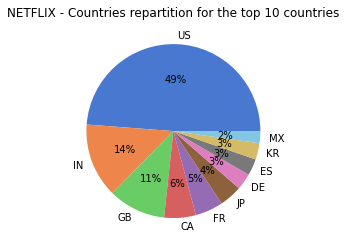

countries ................................................. END


In [32]:
# Affichage des graphiques
# define Seaborn color palette to use
colors = sns.color_palette(getAColorsPaletteSeaborn())

# create pie chart
mp.pyplot.pie("nb_contenus", data=countries_light, labels="Country", colors=colors, autopct='%.0f%%')
mp.pyplot.title("NETFLIX - Countries repartition for the top 10 countries")
mp.pyplot.show()
print("countries ................................................. END")

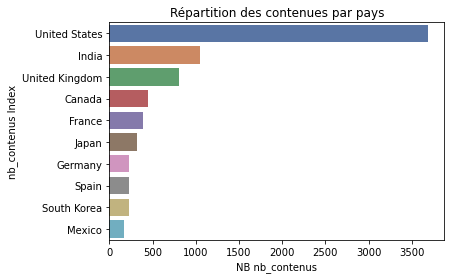

countries ................................................. END


In [33]:
# Affichage des graphiques
displayBarGraphSeabornOneSerie(countries_light, 'nb_contenus', "Répartition des contenues par pays", verbose=verbose, isY=True)
print("countries ................................................. END")

### 8. Commentaires - Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays

Après avoir traiter les données et extraits les 10 Pays, les représentations en camembert ou en histogramme horizontal semblent les plus adaptés


## 9. Tracer un graphe à barres du nombre de films/séries par classement de contenu (rating)

In [34]:
def ratings(df, verbose=False):
    print("9. Tracer un graphe à barres du nombre de films/séries par classement de contenu (rating)")
    rating_df = df.copy()
    if verbose:
        print(rating_df.shape)
        print(rating_df.isna().sum())
    rating_df = rating_df.dropna(subset=['rating'], axis="index")
    if verbose:
        print(rating_df.shape)
        print(rating_df.isna().sum())

    sns.countplot(data=rating_df, hue="type", x="rating",
                  order=rating_df['rating'].value_counts(ascending=False).index)
    plt.xticks(rotation=45)
    plt.title("Netflix - Nombre de films/séries par classement de contenu (rating)")
    plt.show(block=False)

9. Tracer un graphe à barres du nombre de films/séries par classement de contenu (rating)


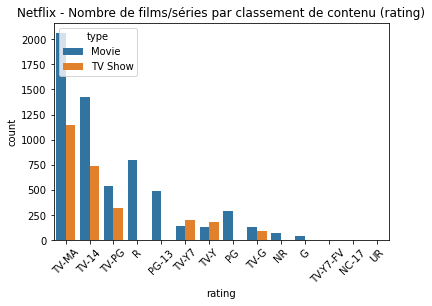

rating ................................................. END


In [35]:
ratings(df, verbose)
print("rating ................................................. END")

In [36]:
print(df["rating"].nunique())
df['rating'].value_counts(ascending=False)

14


TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: rating, dtype: int64

### 9. Commentaire

* TV-Y : Ce programme est évalué comme étant approprié aux enfants.
* TV-Y7 : Ce programme est désigné pour les enfants âgés de 7 ans et plus.
* TV-G : La plupart des parents peuvent considérer ce programme comme approprié pour les enfants
* TV-PG : Ce programme contient des éléments que les parents peuvent considérer inappropriés pour les enfants
* TV-14 : Ce programme contient des éléments que les parents peuvent considérer inappropriés pour les enfants âgés de moins de 14 ans
* TV-MA :  Ce programme est uniquement réservé aux adultes et inapproprié pour la jeune audience de moins de 17 ans

Les programmes disponibles sur Netflix sont majoritairement destinés aux adultes (TV-MA et TV-14).
On peut se demander si les productions ne prennent aucun risque et positionnent les programmes dans les catégories les plus restrictives pour reporter la responsabilité sur le consommateur.
Ou encore les programmes sont majoritairement adultes car les clients / utilisateurs sont majoritairement des adultes ? 
Il faudrait les données relatives aux utilisateurs pour approfondir l'analyse du type de contenu.

## 10. Tracer un graphique qui montre l'évolution du nombre de films/séries produits par les 10 pays les plus producteurs de contenus sur Netflix, au fil des ans

In [37]:
# ---------------------------------------------------------------------------------------------
#                               Préparation des données
# ---------------------------------------------------------------------------------------------
def countries_progress_prepare_data(df, countries_light, verbose=False):
    t0 = time()
    country_prog_df = df.copy()
    countries_light = countries_light.copy()

    # Ajout des années en colonnes du DF countries_light
    # les valeurs étant le nombre de films
    years = country_prog_df["release_year"].unique()
    years = years.tolist()
    # Trie des années par ordre chronologique pour le tableau
    years = sorted(years)
    print(years)
    for year in years:
        countries_light[year] = 0

    # Ajoute une colonne pour le pays concerné avec True or False si le pays a contribué
    # Donc 10 colonnes sont ajoutées au dataset
    for pays_name in countries_light.index:
        country_prog_df = process_country_version2(country_prog_df, pays_name, verbose)
        country_prog_df.loc[country_prog_df[pays_name] == False, pays_name] = np.nan
        if verbose:
            print(country_prog_df.shape)
        # Récupération du nombre par an
        group_year = country_prog_df.groupby("release_year")[pays_name].value_counts()
        # Ajout le total dans le countries_light de chaque année
        for y in group_year.index:
            countries_light.loc[pays_name, y] = group_year[y]

    if verbose:
        print(countries_light.shape)
        print(countries_light.columns)
        print(countries_light.head(10))

    # Inversion des colonnes et des lignes
    countries_light_country_columns = countries_light.transpose()
    if verbose:
        countries_light_country_columns.head(10)
    
    # suppression des colonnes inutiles
    countries_light_country_columns = countries_light_country_columns.drop(
        ['nb_contenus', 'Country', 'Continent', 'Latitude', 'Longitude', 1.0])
    
    countries_light_years_columns = countries_light_country_columns.transpose()
        
    if verbose:
        print(countries_light_years_columns.head(10))
        print(countries_light_years_columns.dtypes)
        print("-----------------------------------")
        print(countries_light_country_columns.head(10))
        print(countries_light_country_columns.dtypes)
        
    # correction des types
    for colname in countries_light_country_columns.columns:
        countries_light_country_columns[colname] = pd.to_numeric(countries_light_country_columns[colname])
    
    for colname in countries_light_years_columns.columns:
        countries_light_years_columns[colname] = pd.to_numeric(countries_light_years_columns[colname])
    
    if verbose:
        print(countries_light_years_columns.dtypes)
        print("-----------------------------------")
        print(countries_light_country_columns.dtypes)
      
    t1 = time() - t0
    print("countries_progress_prepare_data in {0:.3f} secondes................................................... END".format(t1))
    return countries_light, years, countries_light_country_columns, countries_light_years_columns

In [38]:
verbose = False
# 10. Tracer un graphique qui montre l'évolution du nombre de films/séries produits par les 10 pays les plus producteurs de contenus sur Netflix, au fil des ans
countries_light, years, countries_light_country_columns, countries_light_years_columns = countries_progress_prepare_data(df, countries_light, verbose)
countries_light_country_columns.head(10)

[1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.345 secondes................... END
India nb_total : 1046  - nb_films : 962  - nb_series : 84
process_country in 0.263 secondes................... END
United Kingdom nb_total : 806  - nb_films : 534  - nb_series : 272
process_country in 0.370 secondes................... END
Canada nb_total : 445  - nb_films : 319  - nb_series : 126
process_country in 0.247 secondes................... END
France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country i

,United States,India,United Kingdom,Canada,France,Japan,Germany,Spain,South Korea,Mexico
1925,0,0,0,0,0,0,0,0,0,0
1942,2,0,0,0,0,0,0,0,0,0
1943,3,0,0,0,0,0,0,0,0,0
1944,3,0,1,0,0,0,0,0,0,0
1945,4,0,0,0,0,0,0,0,0,0
1946,2,0,0,0,0,0,0,0,0,0
1947,1,0,0,0,0,0,0,0,0,0
1954,1,0,0,0,0,0,0,0,0,0
1955,1,0,0,0,1,0,0,0,0,0
1956,1,0,0,0,0,0,0,0,0,0


In [39]:
countries_light_country_columns.dtypes

United States     int64
India             int64
United Kingdom    int64
Canada            int64
France            int64
Japan             int64
Germany           int64
Spain             int64
South Korea       int64
Mexico            int64
dtype: object

In [40]:
countries_light_years_columns.head(10)

,1925,1942,1943,1944,1945,1946,1947,1954,1955,1956,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
United States,0,2,3,3,4,2,1,1,1,1,...,101,112,138,210,348,442,457,428,384,173
India,0,0,0,0,0,0,0,0,0,0,...,41,58,56,70,80,111,101,93,77,35
United Kingdom,0,0,0,1,0,0,0,0,0,0,...,22,29,46,66,102,101,96,68,68,36
Canada,0,0,0,0,0,0,0,0,0,0,...,16,8,30,36,57,58,67,44,39,12
France,0,0,0,0,0,0,0,0,1,0,...,7,16,23,33,52,40,47,49,26,13
Japan,0,0,0,0,0,0,0,0,0,0,...,7,11,16,16,25,37,49,36,24,15
Germany,0,0,0,0,0,0,0,0,0,0,...,6,7,12,14,30,22,14,14,33,9
Spain,0,0,0,0,0,0,0,0,0,0,...,2,6,3,16,31,33,46,32,31,16
South Korea,0,0,0,0,0,0,0,0,0,0,...,11,6,8,16,36,33,34,27,31,20
Mexico,0,0,0,0,0,0,0,0,0,0,...,3,2,4,9,23,20,25,25,23,13


In [41]:
countries_light_years_columns.dtypes

1925    int64
1942    int64
1943    int64
1944    int64
1945    int64
        ...  
2017    int64
2018    int64
2019    int64
2020    int64
2021    int64
Length: 74, dtype: object

In [42]:
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------

In [43]:
df_origin_more_countries = df.copy()
country_names = []

# df_origin_more_countries["annee"] = "01/01/" + str(df_origin_more_countries["release_year"])
# df_origin_more_countries.loc[annee]["annee"] = "01/01/" + str(annee)
df_origin_more_countries["annee"] = pd.to_datetime(df_origin_more_countries["annee"], dayfirst=True)

print(df_origin_more_countries.shape)
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        country_names.append(country)
        df_origin_more_countries = process_country_version2(df_origin_more_countries, country, False)
        df_origin_more_countries[country] = df_origin_more_countries[country].astype(int)
        # df_origin_more_countries.loc[df_origin_more_countries[country] == 0, country] = np.nan
print(df_origin_more_countries.head(10))
print(df_origin_more_countries.shape)
print(df_origin_more_countries.dtypes)

(8807, 14)
United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.454 secondes................... END
India nb_total : 1046  - nb_films : 962  - nb_series : 84
process_country in 1.617 secondes................... END
United Kingdom nb_total : 806  - nb_films : 534  - nb_series : 272
process_country in 0.540 secondes................... END
Canada nb_total : 445  - nb_films : 319  - nb_series : 126
process_country in 0.316 secondes................... END
France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country in 0.764 secondes................... END
Japan nb_total : 318  - nb_films : 119  - nb_series : 199
process_country in 0.517 secondes................... END
Germany nb_total : 231  - nb_films : 185  - nb_series : 46
process_country in 0.484 secondes................... END
Spain nb_total : 232  - nb_films : 171  - nb_series : 61
process_country in 0.405 secondes................... END
South Korea nb_total : 231  - nb_films : 61  - nb

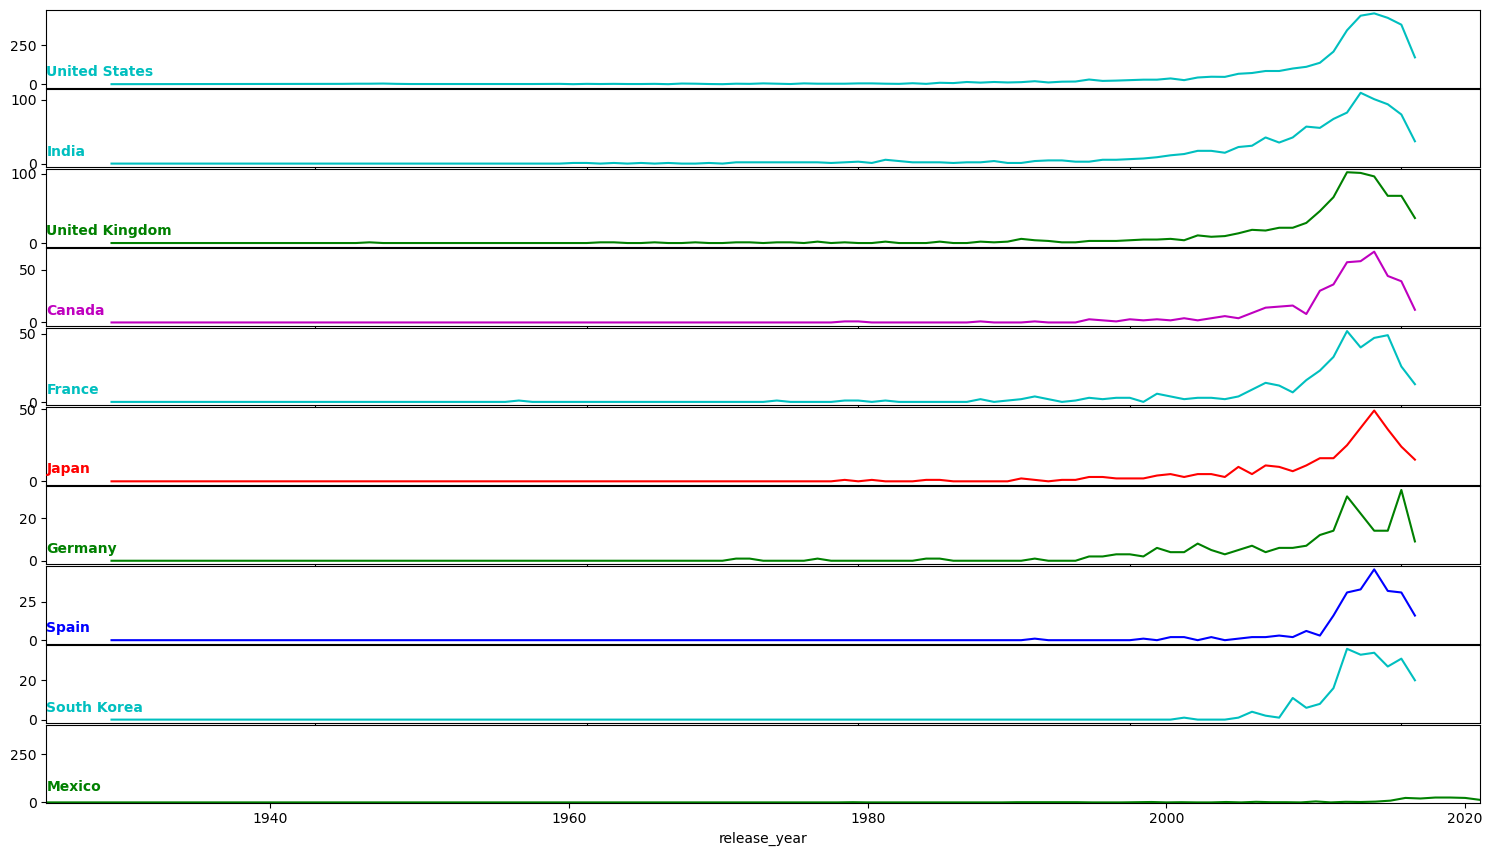

In [223]:
# Define and use a simple function to label the plot in axes coordinates
figure, axes = plt.subplots(len(country_names),1)
i = 0   

used_colors = []

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        color = getAColor()
        used_colors.append(color)
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        countryGroup.plot(ax=axes[i], color=color)
        axes[i].set_autoscaley_on(False)
        axes[i].text(0, .2, country, fontweight="bold", color=color, ha="left", va="center", transform=axes[i].transAxes)
        #plt.ylim([-1,400])
        plt.ylim(-1, 400) 
        i+= 1

figure.set_size_inches(18.5, 10.5, forward=True)
figure.set_dpi(100)
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,400))     
plt.xlim([min(years),max(years)])
#plt.ylim([0,400])
#plt.ylim(-1, 4)
plt.subplots_adjust(wspace=1000)
plt.subplots_adjust(hspace=.02)

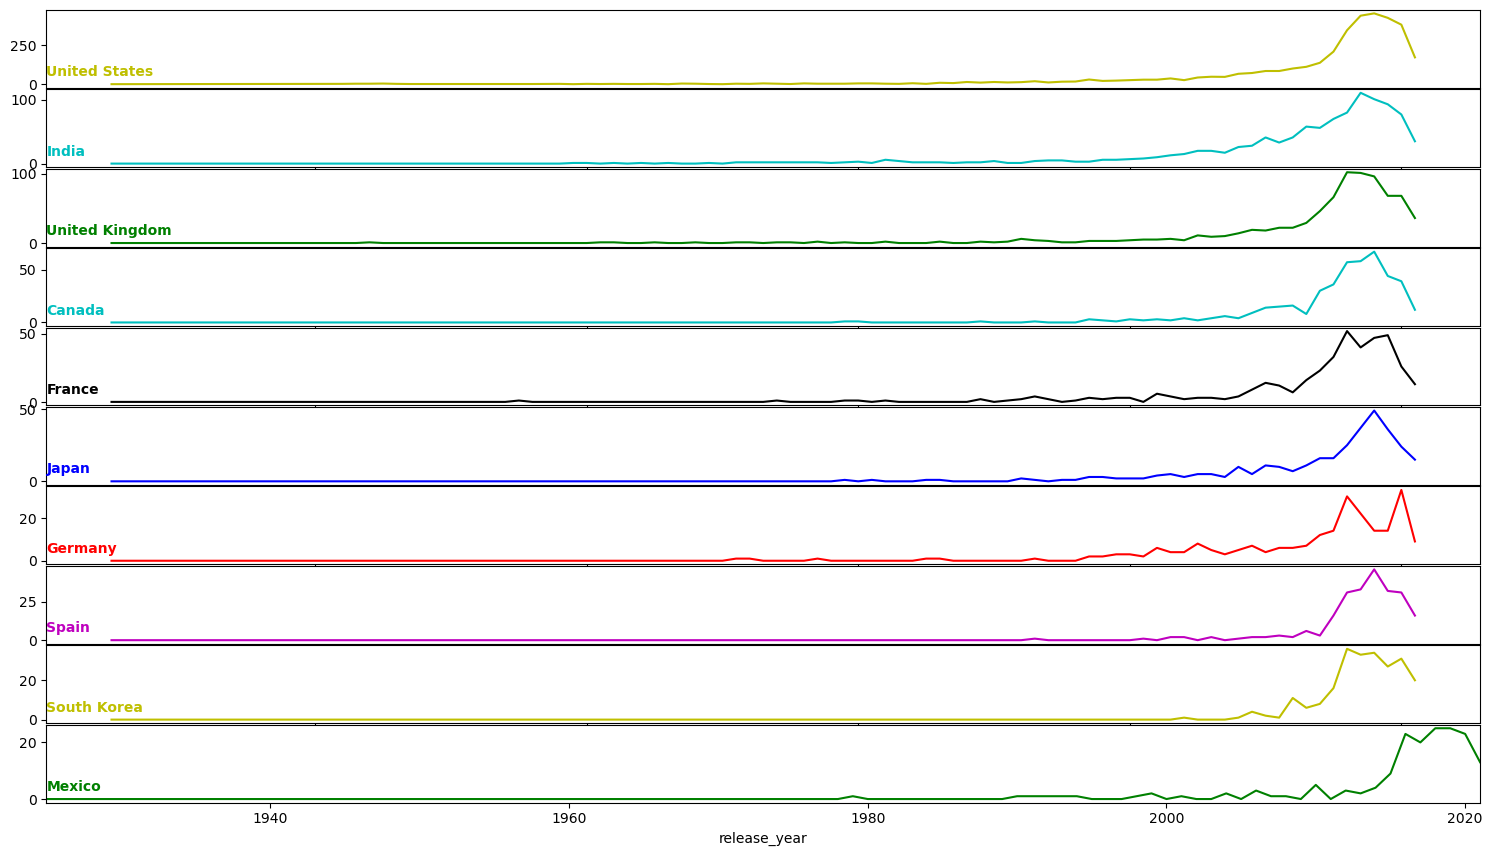

In [224]:
# Define and use a simple function to label the plot in axes coordinates
figure, axes = plt.subplots(len(country_names),1)
i = 0   

used_colors = []

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        color = getAColor()
        used_colors.append(color)
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        countryGroup.plot(ax=axes[i], color=color)
        axes[i].set_autoscaley_on(False)
        axes[i].text(0, .2, country, fontweight="bold", color=color, ha="left", va="center", transform=axes[i].transAxes)
        i+= 1

figure.set_size_inches(18.5, 10.5, forward=True)
figure.set_dpi(100)
        
plt.xlim([min(years),max(years)])
plt.subplots_adjust(wspace=1000)
plt.subplots_adjust(hspace=.02)

## 11. Distribution de la durée des films disponibles sur Netflix

### 11. Commentaire
Après une première analyse des graphes obtenus, il s'avère que les données contiennent beaucoup de valeurs d'une durée très faible.
Il y a donc 3 possibilités :
* 11.A - Les laisser apparaître
* 11.B - Supprimer les enregistrements en dessous d'une certaine durée (quelle durée choisir)
* 11.C - Regrouper les valeurs par zone

La solution dépend de ce que l'on souhaite analyser et de l'objectif de l'étude.

### 11.A Laisser les données tel que reçues

In [111]:
# Extraction des données concernées
df_duration=df[["type", "duration time"]]
df_duration = df_duration.dropna()
# Données spécifiques aux films
df_movies=df_duration[df_duration["type"] == "Movie"]
print("movies",df_movies.shape, "VS duration",df_duration.shape, "VS df", df.shape)
df_movies.head(10)

movies (6131, 2) VS duration (8807, 2) VS df (8807, 14)


,type,duration time
0,Movie,90
6,Movie,91
7,Movie,125
9,Movie,104
12,Movie,127
13,Movie,91
16,Movie,67
18,Movie,94
22,Movie,161
23,Movie,61


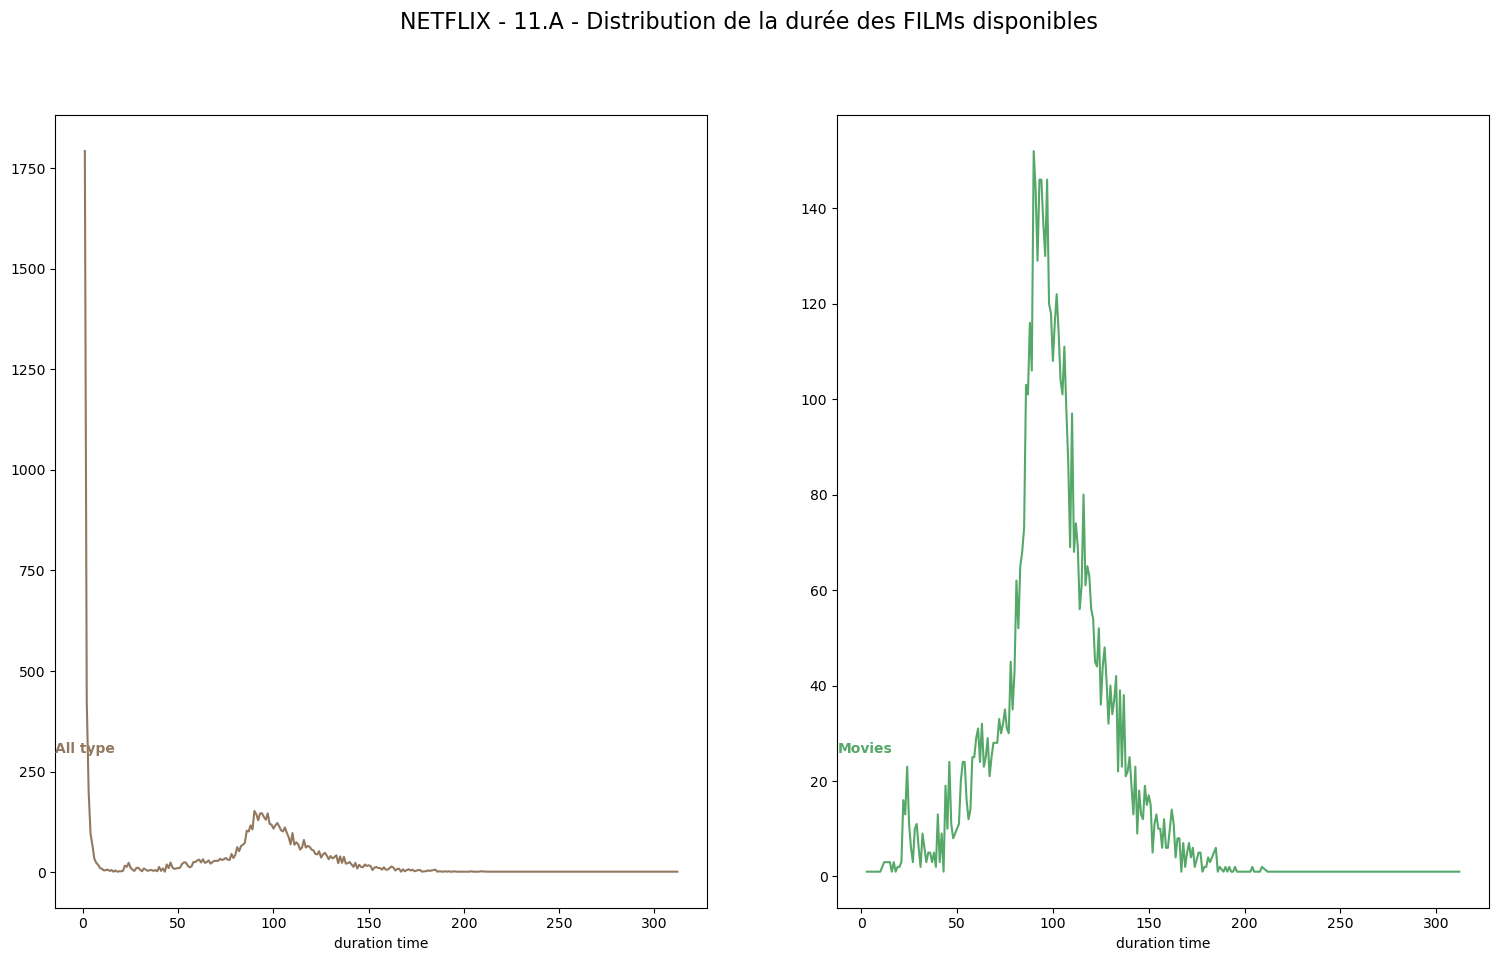

In [113]:
# Define and use a simple function to label the plot in axes coordinates
figure, axes = plt.subplots(1,2)

color = getAColor()

durationGroup =  df_duration.groupby("duration time")["type"].count()
durationGroup.plot(ax=axes[0], color=color)
axes[0].set_autoscaley_on(False)
axes[0].text(0, .2, "All type", fontweight="bold", color=color, ha="left", va="center", transform=axes[0].transAxes)

color = getAColor()
durationMovieGroup =  df_movies.groupby("duration time")["type"].count()
durationMovieGroup.plot(ax=axes[1], color=color)
axes[1].set_autoscaley_on(False)
axes[1].text(0, .2, "Movies", fontweight="bold", color=color, ha="left", va="center", transform=axes[1].transAxes)

figure.set_size_inches(18.5, 10.5, forward=True)
figure.set_dpi(100)
figure.suptitle("NETFLIX - 11.A - Distribution de la durée des FILMs disponibles", fontsize=16)

mp.pyplot.show()

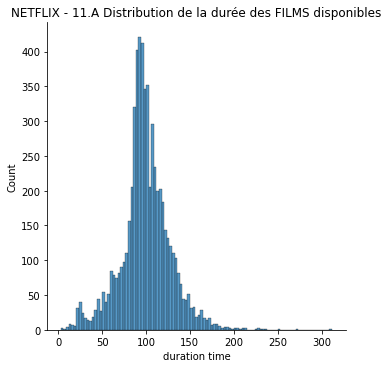

In [120]:
sns.displot(df_movies, x="duration time")
mp.pyplot.title("NETFLIX - 11.A Distribution de la durée des FILMS disponibles")
mp.pyplot.show()

### 11.B - Supprimer les enregistrements en dessous d'une certaine durée (quelle durée choisir)

In [101]:
# identification des données disponibles
# Extraction des données concernées
durations_unique = sorted(df["duration time"].unique())
durations_unique

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 185,
 186,
 187,
 189

On peut voir avec les graphes précédents qu'il y a énormément de contenus avec des durées inférieures à 10 min.
Afin d'analyser le reste des données plus précisément, nous allons retirer ces données.

In [125]:
# Extraction des données concernées
df_duration_minus_min_duration=df_duration[df_duration["duration time"] > 10]
print(df_duration_minus_min_duration.shape, "vs", df_duration.shape)
# Données spécifiques aux films
df_duration_minus_min_duration_movies=df_duration_minus_min_duration[df_duration["type"] == "Movie"]
print("movies",df_movies.shape, "VS duration",df_duration.shape, "VS df", df.shape)
print("movies",df_duration_minus_min_duration_movies.shape, "VS duration",df_duration_minus_min_duration.shape)
df_duration_minus_min_duration_movies.head(10)

(6136, 2) vs (8807, 2)
movies (6131, 2) VS duration (8807, 2) VS df (8807, 14)
movies (6126, 2) VS duration (6136, 2)


<ipython-input-125-dab88dc74313>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_duration_minus_min_duration_movies=df_duration_minus_min_duration[df_duration["type"] == "Movie"]


,type,duration time
0,Movie,90
6,Movie,91
7,Movie,125
9,Movie,104
12,Movie,127
13,Movie,91
16,Movie,67
18,Movie,94
22,Movie,161
23,Movie,61


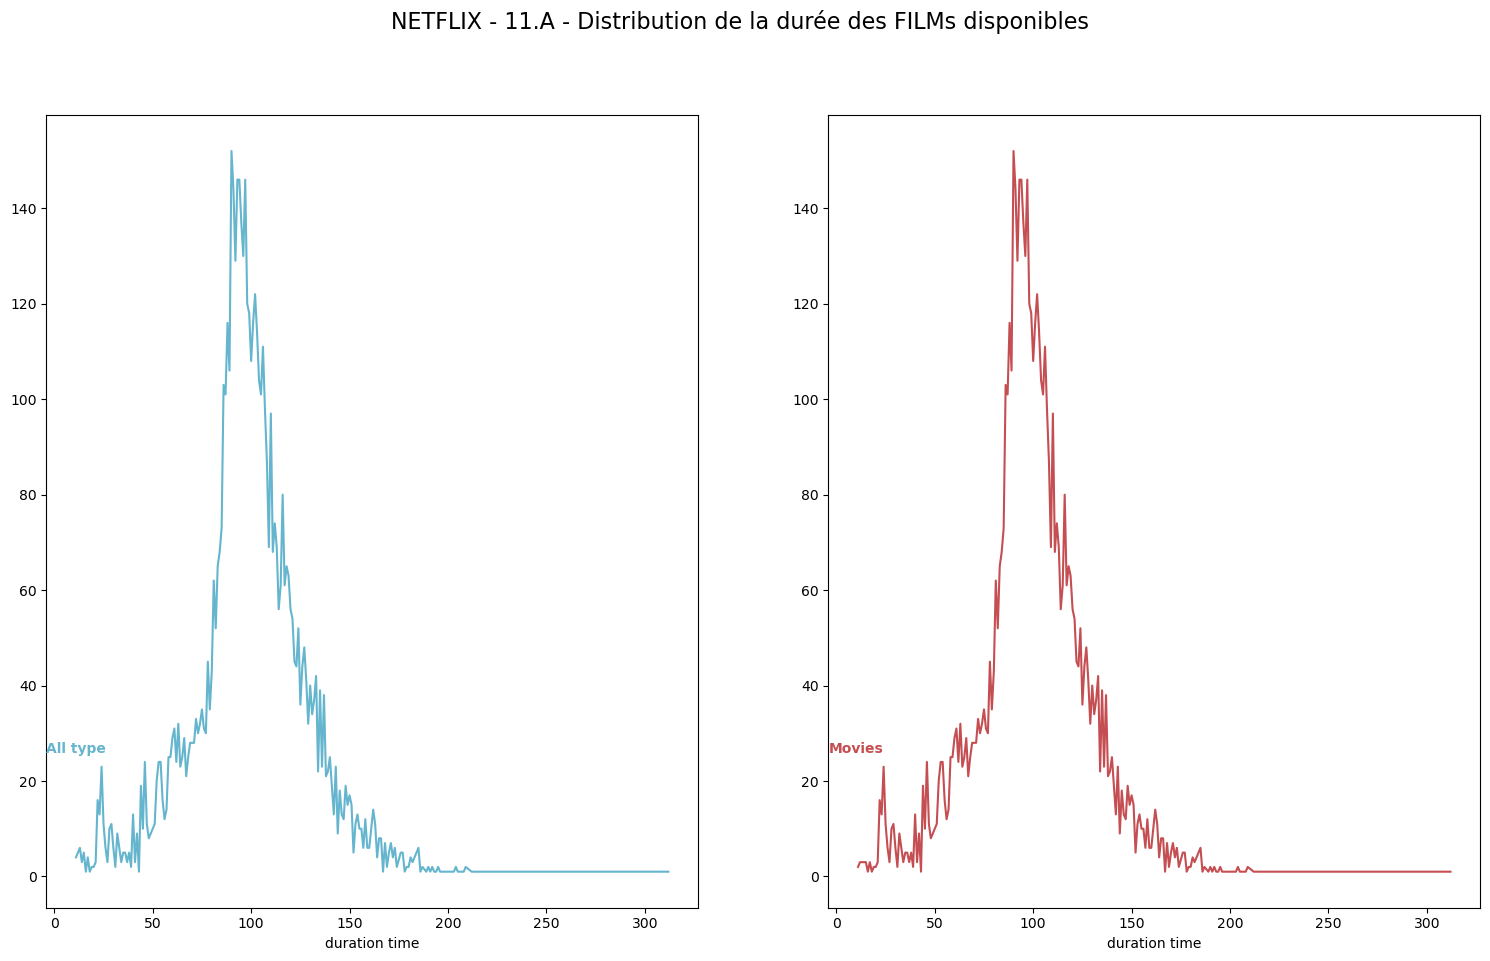

In [126]:
# Define and use a simple function to label the plot in axes coordinates
figure, axes = plt.subplots(1,2)

color = getAColor()

durationGroup =  df_duration_minus_min_duration.groupby("duration time")["type"].count()
durationGroup.plot(ax=axes[0], color=color)
axes[0].set_autoscaley_on(False)
axes[0].text(0, .2, "All type", fontweight="bold", color=color, ha="left", va="center", transform=axes[0].transAxes)

color = getAColor()
durationMovieGroup =  df_duration_minus_min_duration_movies.groupby("duration time")["type"].count()
durationMovieGroup.plot(ax=axes[1], color=color)
axes[1].set_autoscaley_on(False)
axes[1].text(0, .2, "Movies", fontweight="bold", color=color, ha="left", va="center", transform=axes[1].transAxes)

figure.set_size_inches(18.5, 10.5, forward=True)
figure.set_dpi(100)
figure.suptitle("NETFLIX - 11.A - Distribution de la durée des FILMs disponibles", fontsize=16)

mp.pyplot.show()

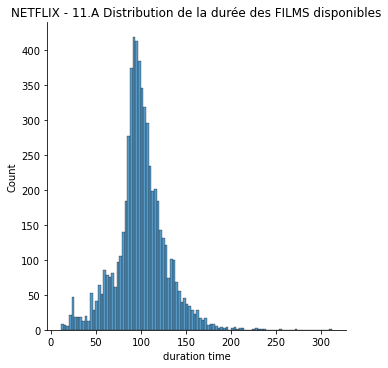

In [127]:
sns.displot(df_duration_minus_min_duration_movies, x="duration time")
mp.pyplot.title("NETFLIX - 11.A Distribution de la durée des FILMS disponibles")
mp.pyplot.show()

### 11.C - Regrouper les valeurs par zone

Nous allons créer une colonne avec des zones de durées :
* '< 30     
* '>= 30 et < 60     
* '>= 60 et < 90     
* '>= 90 et < 120     
* '>= 120     

In [142]:
def category_duree(duree):
    if duree < 30:
        return "< 30 min"
    elif 30 <= duree < 60:
        return '30-60 min'
    elif 60 <= duree < 90:
        return '60-90 min'
    elif 90 <= duree < 120:
        return '90-120 min'
    else:
        return "> 120 min"
    

In [131]:
# Extraction des données concernées
df_duration_categories=df_duration.copy()
df_duration_categories["duration categorie"] = df_duration_categories["duration time"].map(category_duree)
# Conversion des notes en catégorie
df_duration_categories["duration categorie"] = df_duration_categories["duration categorie"].astype('category')

df_duration_categories.head(10)

,type,duration time,duration categorie
0,Movie,90,90-120 min
1,TV Show,2,< 30 min
2,TV Show,1,< 30 min
3,TV Show,1,< 30 min
4,TV Show,2,< 30 min
5,TV Show,1,< 30 min
6,Movie,91,90-120 min
7,Movie,125,> 120 min
8,TV Show,9,< 30 min
9,Movie,104,90-120 min


In [133]:
# Extraction des données concernées
df_duration_categories_movies=df_duration_categories[df_duration_categories["type"] == "Movie"]
print("movies",df_movies.shape, "VS duration",df_duration.shape, "VS df", df.shape)
print("movies",df_duration_minus_min_duration_movies.shape, "VS duration",df_duration_minus_min_duration.shape)
print("movies",df_duration_categories_movies.shape, "VS duration",df_duration_categories.shape)
df_duration_categories_movies.head(10)

movies (6131, 2) VS duration (8807, 2) VS df (8807, 14)
movies (6126, 2) VS duration (6136, 2)
movies (6131, 3) VS duration (8807, 3)


,type,duration time,duration categorie
0,Movie,90,90-120 min
6,Movie,91,90-120 min
7,Movie,125,> 120 min
9,Movie,104,90-120 min
12,Movie,127,> 120 min
13,Movie,91,90-120 min
16,Movie,67,60-90 min
18,Movie,94,90-120 min
22,Movie,161,> 120 min
23,Movie,61,60-90 min


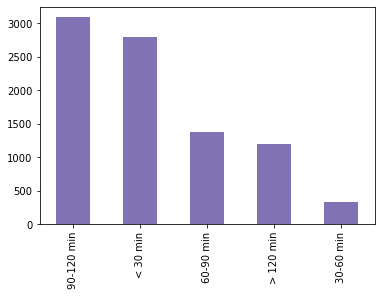

In [132]:
df_duration_categories["duration categorie"].value_counts().plot.bar(color=getAColor())
plt.show()

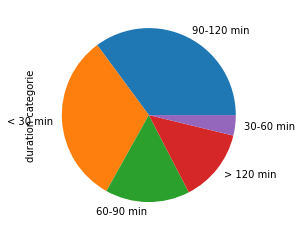

In [141]:
df_duration_categories["duration categorie"].value_counts().plot.pie()
plt.show()

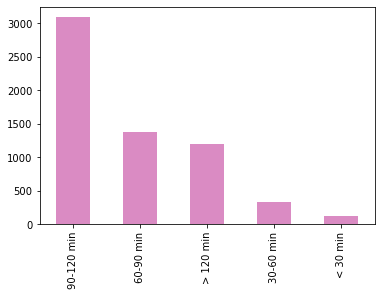

In [134]:
df_duration_categories_movies["duration categorie"].value_counts().plot.bar(color=getAColor())
plt.show()

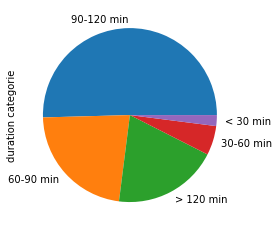

duration ................................................. END


In [140]:
df_duration_categories_movies["duration categorie"].value_counts().plot.pie()
plt.show()
print("duration ................................................. END")

### 11. Conclusion
La version par catégorie semble la plus pertinente dans le contexte de ce projet pour une première analyse.       
La moitié des films sont entre 1h30 et 2h.       
Pour ce qui est des films d'une durée inférieure à une durée de 30 minutes, il pourrait être intéressant de les coupler avec les types de films, par exemple, voir s'il s'agit des films d'arts et d'essais       
De même, il pourrait être intéressant de voir les catégories de films les plus longs       

## 12. Tracer un graphique représentant le nombre de séries par modalité de nombre de saisons

In [242]:
df_season = df[df["type"] == "TV Show"]
df_season

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,season,duration time,annee
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,NaN,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2 Seasons,NaN,2021-01-01
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,NaN,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1 Season,NaN,2021-01-01
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,NaN,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1 Season,NaN,2021-01-01
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,NaN,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2 Seasons,NaN,2021-01-01
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,2021-09-24,2021,TV-MA,NaN,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,1 Season,NaN,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,s8796,TV Show,Yu-Gi-Oh! Arc-V,NaN,"Mike Liscio, Emily Bauer, Billy Bob Thompson, ...","Japan, Canada",2018-05-01,2015,TV-Y7,NaN,"Anime Series, Kids' TV",Now that he's discovered the Pendulum Summonin...,2 Seasons,NaN,2015-01-01
8796,s8797,TV Show,Yunus Emre,NaN,"Gökhan Atalay, Payidar Tüfekçioglu, Baran Akbu...",Turkey,2017-01-17,2016,TV-PG,NaN,"International TV Shows, TV Dramas","During the Mongol invasions, Yunus Emre leaves...",2 Seasons,NaN,2016-01-01
8797,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia",2018-09-13,2016,TV-Y7,NaN,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,3 Seasons,NaN,2016-01-01
8800,s8801,TV Show,Zindagi Gulzar Hai,NaN,"Sanam Saeed, Fawad Khan, Ayesha Omer, Mehreen ...",Pakistan,2016-12-15,2012,TV-PG,NaN,"International TV Shows, Romantic TV Shows, TV ...","Strong-willed, middle-class Kashaf and carefre...",1 Season,NaN,2012-01-01


In [243]:
df_season = df_season[["type", "season"]]
df_season

,type,season
1,TV Show,2 Seasons
2,TV Show,1 Season
3,TV Show,1 Season
4,TV Show,2 Seasons
5,TV Show,1 Season
...,...,...
8795,TV Show,2 Seasons
8796,TV Show,2 Seasons
8797,TV Show,3 Seasons
8800,TV Show,1 Season


In [244]:
df_season = df_season.dropna()
df_season

,type,season
1,TV Show,2 Seasons
2,TV Show,1 Season
3,TV Show,1 Season
4,TV Show,2 Seasons
5,TV Show,1 Season
...,...,...
8795,TV Show,2 Seasons
8796,TV Show,2 Seasons
8797,TV Show,3 Seasons
8800,TV Show,1 Season


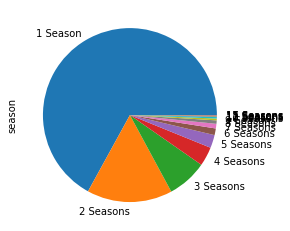

Season ................................................. END


In [245]:
df_season["season"].value_counts().plot.pie()
plt.show()
print("Season ................................................. END")

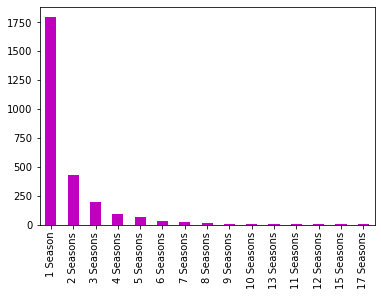

In [248]:
df_season["season"].value_counts().plot.bar(color=getAColor())
plt.show()

------------------------------------------------------------------------------------------------------------------------
# BROUILLONS
------------------------------------------------------------------------------------------------------------------------

## 3. Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?
### VERSION 1

In [49]:
def process_country(df, country, verbose=False):
    """
    Créé une copie du DataFrame, y ajoute une colonne pour le pays souhaité avec un boolean si le contenu vient de ce pays = True
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new DataFrame avec la colonne pour le pays
    """
    t0 = time()
    df_country = df.copy()
    df_country[country] = df_country["country"].str.contains(country, case=False)
    if verbose:
        nb_total = df_country[country].value_counts()[True]
        select = df_country[df_country["type"] == "Movie"].index.intersection(df_country[df_country[country] == True].index)
        nb_films = len(select)
        select = df_country[df_country["type"] == "TV Show"].index.intersection(df_country[df_country[country] == True].index)
        nb_series = len(select)
        print(country, "nb_total :", nb_total, " - nb_films :", nb_films, " - nb_series :", nb_series)
    t1 = time() - t0
    print("process_country in {0:.3f} secondes................... END".format(t1))
    return df_country

In [50]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|                      Questions                |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?")
if verbose: print("country : ", df["country"].unique())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|                      Questions                |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combien de films/séries ont été produit par les Etats-Unis ? Par la France ?


In [51]:
df_states = process_country(df, states, True)

United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.085 secondes................... END


In [52]:
df_france = process_country(df_states, france, True)

France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country in 0.094 secondes................... END


In [53]:
# Films en collaboration France / Etats Unis
select = df_france[df_france[states] == True].index.intersection(df_france[df_france[france] == True].index)
print("Films en colaboration France / Etats Unis :", len(select.value_counts()))

Films en colaboration France / Etats Unis : 125


### VERSION 1 - Conclusion : Les résultats sont différents avec la suite 2nd partie du rapport
J'ai donc recherché une autre façon de le calculer pour m'assurer que je trouvais les mêmes résultats

- 2750  pour  United States au lieu de nb_total : 3690  - nb_films : 2752  - nb_series : 938
- 311 pour France au lieu de nb_total : 393  - nb_films : 303  - nb_series : 90

# Etude des contenus - VERSION 1
5. Etude des catégories avec le plus de contenu
6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

Pour ces 3 questions, un traitement commun est mis sous forme de fonction.

In [54]:
def get_unique_data(df, column_name, verbose=False):
    """
    Compte le nombre de contenu unique pour la colonne reçue et revoi le
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param verbose : Boolean - True pour mode debug
    :return: dic{<data_value>:<data_count>}, dic{<data_count>:[<data_values>]}, max int
    """
    t0 = time()
    df = df.copy()
    categories_list = {}
    categories_by_size = {}
    max = 0
    if verbose: print(column_name, " : ", df[column_name].unique())
    for cats_str in df[column_name].unique():
        if cats_str is None or cats_str == np.nan or type(cats_str) != str:
            continue
        cats = cats_str.split(",")
        for cat in cats:
            cat = cat.strip()
            if len(cat) > 0 and cat not in categories_list:
                # comptage du nombre d'élément par catégorie
                nb = count_unique_data(df, column_name, cat, False)
                categories_list[cat] = nb
                if not categories_by_size.get(nb, False):
                    categories_by_size[nb] = []
                categories_by_size[nb].append(cat)
                if verbose:
                    print(nb," : " , cat)
                if nb > max:
                    max = nb
    t1 = time() - t0
    print("get_unique_data in {0:.3f} secondes................... END".format(t1))
    return categories_list, categories_by_size, max

In [55]:
categories(df, verbose, version=1)

Etude des catégories avec le plus de contenu.
get_unique_data in 1.817 secondes................... END
Nb Catégories : 42 in 1.817 secondes
Catégories avec le plus de contenus : 4502
MAX= 4502 soit : ['Movies']
4502  pour  ['Movies']
3190  pour  ['Dramas']
2752  pour  ['International Movies']
2255  pour  ['Comedies']
1755  pour  ['TV Shows']
1351  pour  ['International TV Shows']
1027  pour  ['Action & Adventure']
869  pour  ['Documentaries']
763  pour  ['TV Dramas']
756  pour  ['Independent Movies']
categories in 1.817 secondes................... END


## 6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?

In [56]:
directors(df, verbose, version=1)

Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
get_unique_data in 161.166 secondes................... END
Nb directors : 4993 in 161.166 secondes
Directors avec le plus de contenus : ['Ram'] avec : 78 contenus
78  pour  ['Ram']
22  pour  ['Rajiv Chilaka']
21  pour  ['Jan Suter']
20  pour  ['Raúl Campos']
16  pour  ['Suhas Kadav', 'Marcus Raboy']
15  pour  ['McG', 'Jay Karas']
14  pour  ['Vijay']
13  pour  ['Cathy Garcia-Molina', 'LP']
12  pour  ['Youssef Chahine', 'Martin Scorsese', 'Jay Chapman', 'Jami']
11  pour  ['Steven Spielberg']
directors in 161.166 secondes................... END


### Commentaire

Cette première version prend un peu de temps, à voir pour faire une version plus optimisée

## 7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

In [57]:
james_suter(df, True, version=1)

Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?
james_suter - BEFORE drop NA (8807, 14)
james_suter - AFTER drop NA (6173, 14)
james_suter - nb contenus (21, 14)
cast  :  ['Coco Celis, Raúl Meneses' 'Luciano Mellera' 'Jani Dueñas'
 'Fernando Sanjiao' 'Carlos Ballarta' 'Lucas Lauriente'
 'Sofía Niño de Rivera' 'Malena Pichot' 'Natalia Valdebenito'
 'Sebastián Marcelo Wainraich' 'Ricardo Quevedo'
 'Julián Arango, Antonio Sanint' 'Alexis de Anda' 'Alex Fernández'
 'Alan Saldaña' 'Manu NNa' 'Daniel Sosa'
 'Ricardo O\'Farrill, Carlos Ballarta, Sofía Niño de Rivera, Chumel Torres, Marissa "Chabe" Lozano'
 "Ricardo O'Farrill"]
1  :  Coco Celis
1  :  Raúl Meneses
1  :  Luciano Mellera
1  :  Jani Dueñas
1  :  Fernando Sanjiao
3  :  Carlos Ballarta
1  :  Lucas Lauriente
3  :  Sofía Niño de Rivera
1  :  Malena Pichot
1  :  Natalia Valdebenito
1  :  Sebastián Marcelo Wainraich
1  :  Ricardo Quevedo
1  :  Julián Arango
1  :  Antonio Sanint
1  :  Alexis de Anda
1  :  Alex Fernández
1

## Graphiques

In [58]:
from folium.plugins import MarkerCluster

##################### MAP
world_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)

# for each coordinate, create circlemarker of user percent
for i in range(len(countries_df)):
    lat = countries_df.iloc[i]['Latitude']
    long = countries_df.iloc[i]['Longitude']
    if lat != "" and long != "":
        radius = (countries_df.iloc[i]['nb_contenus'])/100
        popup_text = str(countries_df.iloc[i]['nb_contenus'])
        folium.CircleMarker(location=(lat, long), radius=radius, popup=popup_text, fill=False).add_to(marker_cluster)
        
# show the map
world_map

## Graphiques - Commentaire

Cette carte ne présente pas les informations telles que je souhaiterai les faire apparaître

In [ ]:
# ---------------------------------------------------------------------------------------------
#                               Préparation des données
# ---------------------------------------------------------------------------------------------
def countries_progress_prepare_data_old(df, countries_light, verbose=False):
    t0 = time()
    country_prog_df = df.copy()
    countries_light = countries_light.copy()

    # Ajout des années en colonnes du DF countries_light
    # les valeurs étant le nombre de films
    years = country_prog_df["release_year"].unique()
    years = years.tolist()
    # Trie des années par ordre chronologique pour le tableau
    years = sorted(years)
    print(years)
    for year in years:
        countries_light[year] = 0

    # Ajoute une colonne pour le pays concerné avec True or False si le pays a contribué
    # Donc 10 colonnes sont ajoutées au dataset
    for pays_name in countries_light.index:
        country_prog_df = process_country_version2(country_prog_df, pays_name, verbose)
        country_prog_df.loc[country_prog_df[pays_name] == False, pays_name] = np.nan
        if verbose:
            print(country_prog_df.shape)
        # Récupération du nombre par an
        group_year = country_prog_df.groupby("release_year")[pays_name].value_counts()
        # Ajout le total dans le countries_light de chaque année
        for y in group_year.index:
            countries_light.loc[pays_name, y] = group_year[y]

    if verbose:
        print(countries_light.shape)
        print(countries_light.columns)
        print(countries_light.head(10))

    # Inversion des colonnes et des lignes
    countries_light_country_columns = countries_light.transpose()
    if verbose:
        countries_light_country_columns.head(10)
    
    # suppression des colonnes inutiles
    countries_light_country_columns = countries_light_country_columns.drop(
        ['nb_contenus', 'Country', 'Continent', 'Latitude', 'Longitude', 1.0])
    
    countries_light_years_columns = countries_light_country_columns.transpose()
    # correction des types
    for colname in countries_light_years_columns.columns:
        countries_light_years_columns[colname] = pd.to_numeric(countries_light_years_columns[colname])
    if verbose:
        print(countries_light_years_columns.dtypes)
    
    countries_light_country_columns["idx_annee"] = ""
    for annee in countries_light_country_columns.index:
        countries_light_country_columns.loc[annee]["idx_annee"] = "01/01/"+str(annee)
       
    if verbose:
        print(countries_light_country_columns.head(10))
        print(countries_light_country_columns.dtypes)
        
    # correction des types
    for colname in countries_light_country_columns.columns:
        if colname != "idx_annee":
            countries_light_country_columns[colname] = pd.to_numeric(countries_light_country_columns[colname])
    countries_light_country_columns["idx_annee"] = pd.to_datetime(countries_light_country_columns["idx_annee"], dayfirst=True)
    if verbose:
        print(countries_light_country_columns.dtypes)

        
    
        
    t1 = time() - t0
    print("countries_progress_prepare_data in {0:.3f} secondes................................................... END".format(t1))
    return countries_light, years, countries_light_country_columns, countries_light_years_columns

In [ ]:
sns.displot(data=countries_light_country_columns, x="idx_annee", kind="kde")

In [ ]:
for colname in countries_light_country_columns.columns:
        sns.displot(data=countries_light_country_columns, x=colname, kind="kde")

In [ ]:
sns.displot(data=countries_light_country_columns, x="idx_annee", kind="kde")
for colname in countries_light_country_columns.columns:
    if colname != "idx_annee":
        sns.displot(data=countries_light_country_columns, x="idx_annee", y=colname, kind="kde")

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

for colname in countries_light_country_columns.columns:
    if colname != "idx_annee":
        sns.displot(data=countries_light_country_columns, x="idx_annee", y=colname, palette=pal)

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

for colname in countries_light_country_columns.columns:
    if colname != "idx_annee":
        sns.kdeplot(data=countries_light_country_columns, x="idx_annee", y=colname, palette=pal, shade=True)

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        g = sns.FacetGrid(data=df_origin_more_countries, col="release_year", row=country, palette=pal, aspect=15, height=.5)
        g = g.map(plt.hist, "Contenu par année")
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(country)
plt.show()

In [ ]:
for colname in countries_light_country_columns.columns:
    if colname != "idx_annee":
        sns.kdeplot(countries_light_country_columns[colname], shade=True)
plt.show()

In [ ]:
def process_add_10_country_DF(df, search_data, verbose=False):
    t0 = time()
    df = df.copy()
    df_data = df["country"].str.split(",", n=0, expand=True)
        
    set_liste_data = set()
    if verbose:
        print(df_data.shape)
        print(df_data.columns)
    nb_col = df_data.shape[1]
    # Construction de la liste de données uniques
    for i in range(nb_col):
        set_liste_data = set_liste_data | set(df_data[i].str.strip())
    
    
    for to_add_country in set_liste_data:
        if to_add_country in search_data:
            df[to_add_country] = to_add_country[]
    
    if verbose:
        print(df_data.shape)
        print(df_data.columns)
    nb_col = df_data.shape[1]    
    
    t1 = time() - t0
    print("get_unique_data_version in {0:.3f} secondes................... END".format(t1))
    return data_list, data_by_size, max

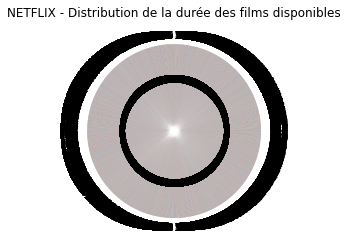

duration plot ................................................. END


In [69]:
# Affichage des graphiques
# define Seaborn color palette to use
colors = sns.color_palette(getAColorsPaletteSeaborn())

# create pie chart
mp.pyplot.pie("duration time", data=df_movies, labels="duration time", colors=colors, autopct='%d')
mp.pyplot.title("NETFLIX - Distribution de la durée des films disponibles")
mp.pyplot.show()
print("duration plot ................................................. END")

In [215]:
pip install geopandas

  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached Fiona-1.8.20.tar.gz (1.3 MB)
  Using cached Fiona-1.8.19.tar.gz (1.3 MB)
  Using cached Fiona-1.8.18.tar.gz (1.3 MB)
  Using cached Fiona-1.8.17.tar.gz (1.3 MB)
  Using cached Fiona-1.8.16.tar.gz (1.3 MB)
  Using cached Fiona-1.8.15.tar.gz (1.3 MB)
  Using cached Fiona-1.8.14.tar.gz (1.3 MB)
  Using cached Fiona-1.8.13.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.13.tar.gz (1.2 MB)
  Using cached Fiona-1.8.12.tar.gz (1.2 MB)
  Using cached Fiona-1.8.11.tar.gz (1.2 MB)
  Using cached Fiona-1.8.10.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post2.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.tar.gz (1.2 MB)
  Using cached Fiona-1.8.8.tar.gz (1.7 MB)
  Using cached Fiona-1.8.7.tar.gz (1.7 MB)
  Using cached Fiona-1.8.6.tar.gz (1.7 MB)
  Using cached Fiona-1.8.5.tar.gz (1.7 MB)
  Using cached Fiona-1.8.4.tar.gz (1.1 MB)
  Using cached Fiona-1.8.3.tar.gz (1.1 MB)
  Usi

    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-59sr2p0v\\fiona_97fe63e749314921a4670eda1a04e753\\setup.py'"'"'; __file__='"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-59sr2p0v\\fiona_97fe63e749314921a4670eda1a04e753\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\User\AppData\Local\Temp\pip-pip-egg-info-i5gerx8w'
         cwd: C:\Users\User\AppData\Local\Temp\pip-install-59sr2p0v\fiona_97fe63e749314921a4670eda1a04e753\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
    ERROR: C

In [214]:
from folium import plugins
from shapely.geometry import Point, shape
import geopandas as gpd

locs_geometry = [Point(xy) for xy in zip(countries_df['Longitude'].values,
                                         countries_df['Latitude'].values)]
crs = {'init': 'epsg:4326'}
# Coordinate Reference Systems, "epsg:4326" is a common projection of WGS84 Latitude/Longitude
locs_gdf = gpd.GeoDataFrame(countries_df, crs=crs, geometry=locs_geometry)

cluster_map = folium.Map(tiles="cartodbpositron")

marker_cluster = plugins.MarkerCluster().add_to(cluster_map)
for i, v in locs_gdf.iterrows():
    popup = """
    Type : <b>%s</b><br>
    Nb contenus : <b>%d</b><br>
    """ % (v['type'], v['nb_contenus'])
    
    if v['type'] == 'Movie':
        folium.CircleMarker(location=[v['Latitude'], v['Longitude']],
                            radius=3,
                            tooltip=popup,
                            color='#FFBA00',
                            fill_color='#FFBA00',
                            fill=True).add_to(marker_cluster)
    else :
        folium.CircleMarker(location=[v['Latitude'], v['Longitude']],
                            radius=3,
                            tooltip=popup,
                            color='#087FBF',
                            fill_color='#087FBF',
                            fill=True).add_to(marker_cluster)
    

ModuleNotFoundError: No module named 'geopandas'